# _PyChOpMarg_ for IEEE 802.3dj

Original author: David Banas <capn.freako@gmail.com>  
Original date:   August 17, 2024

Copyright &copy; 2024 David Banas; all rights reserved World wide.

## Introduction

This [Jupyter](https://jupyter.org) notebook is intended to help debug recent additions made to the [_PyChOpMarg_](https://pychopmarg.readthedocs.io/en/latest/index.html) Python package in support of the coming IEEE 802.3dj Ethernet standard for 100 GBaud. signalling (200 Gbps using PAM-4).  
I run it from my `pychopmarg` Python virtual environment, into which I've installed:

- `jupyter`
- `PyChOpMarg`

This new addition to the 802.3 standard introduces some significant changes to the way equalization optimization is performed for COM analysis.
And I am trying to bring the _PyChOpMarg_ package up-to-date with those changes.
I look at the results of applying COM to certain example channels pertinent to the work of the IEEE 802.3dj task force.

## Imports & Utilities

Here, we import everything we need and define some useful utilities.


In [95]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
import numpy   as np
import re

import skrf as rf

from matplotlib         import pyplot as plt
from matplotlib.ticker  import MultipleLocator
from numpy.fft          import fftshift, irfft, rfft
from pathlib            import Path
from random             import choice, sample
from time               import time
from typing             import Any, Callable, TypeAlias

from pychopmarg.com     import COM, OptMode, calc_Hffe
from pychopmarg.common  import *

ChnlGrpName: TypeAlias = str  # channel group name
ChnlSetName: TypeAlias = str  # channel set name (the stem of the thru channel s4p file name)
ChnlTypName: TypeAlias = str  # channel type name ("thru", "next", or "fext")
ChnlSetComp: TypeAlias = rf.Network | list[rf.Network]   # i.e. - a thru channel, or a list of NEXT/FEXT channels
ChnlSet:     TypeAlias = dict[ChnlTypName, ChnlSetComp]


def fwhm(pr: Rvec) -> float:
    """
    Measure the full width at half maximum of the given pulse response.
    
    Args:
        pr: Pulse response to measure.
        
    Returns:
        fwhm: Full width at half max of largest peak in given signal.

    Notes:
        1. Used to characterize the _bandwidth_ of a given channel.
    """
    pk_loc = np.where(pr == max(pr))[0][0]
    half_max = 0.5 * pr[pk_loc]
    left_hm = pk_loc
    while left_hm > 0 and pr[left_hm] > half_max:
        left_hm -= 1
    right_hm = pk_loc
    while right_hm < (len(pr) - 1) and pr[right_hm] > half_max:
        right_hm += 1
    return right_hm - left_hm


def reflectivity(pr: Rvec) -> float:
    """
    Measure the _reflectivity_ of a channel with the given pulse response.
    
    Args:
        pr: Pulse response of channel.
        
    Returns:
        ref: Reflectivity of channel.

    Notes:
        1. Use sum of: delta-x weighted by power at delta-x.
    """
    pk_loc = np.where(pr == max(pr))[0][0]
    return sum([dn * y**2 for dn, y in enumerate(pr[pk_loc:])])
    

def get_channel_sets(path: Path) -> dict[ChnlGrpName, list[ChnlSet]]:
    """
    Return all available groups of channel sets in the given path.

    Args:
        path: The folder in which to begin searching.
            (Assumed to contain some number of sub-directories,
            in which the actual channel sets are contained.)

    Returns:
        Dictionary of channel groups, each containing a list of channel sets.

    Notes:
        1. A "channel set" is a dictionary containing a thru channel and some number
            of NEXT and FEXT aggressors.
    """
    
    chnl_groups = list(filter(lambda p: p.is_dir(), path.iterdir()))
    chnl_groups.sort()
    channels = {}
    for chnl_grp in chnl_groups:
        channels[chnl_grp.name] = []
        thru_chnls = list(chnl_grp.glob("*[tT][hH][rR][uU]*.[sS]4[pP]"))  # No global option for case insensitive glob().
        thru_chnls.sort()
        for thru_chnl in thru_chnls:
            nexts = list(chnl_grp.glob(re.sub("thru", "[nN][eE][xX][tT][0-9]", thru_chnl.name, flags=re.IGNORECASE)))
            nexts.sort()
            fexts = list(chnl_grp.glob(re.sub("thru", "[fF][eE][xX][tT][0-9]", thru_chnl.name, flags=re.IGNORECASE)))
            fexts.sort()
            channels[chnl_grp.name].append({  # Here we're constructing a "channel set" dictionary.
                "thru": thru_chnl,
                "next": nexts,
                "fext": fexts
            })
    return channels


def run_com(
    chnl_sets: list[tuple[ChnlGrpName, list[ChnlSet]]],
    params: COMParams,
    opt_mode: OptMode = OptMode.MMSE
) -> dict[ChnlGrpName, dict[ChnlSetName, COM]]:
    """
    Run COM on a list of grouped channel sets.

    Args:
        chnl_sets: List of pairs, each consisting of:
            - ch_grp_name: The group name for this list of channel sets.
            - ch_sets: List of channel sets to run.
        params: The COM configuration parameters to use.

    Keyword Args:
        opt_mode: The optimization mode desired.
            Default: OptMode.MMSE
    
    Returns:
        2D dictionary indexed by channel group name, then by channel set name, containing the completed COM objects.
    """

    theCOMs = {}
    for grp, ch_set in chnl_sets:
        lbl = ch_set['thru'].stem
        theCOM = COM()
        theCOM.set_params(params)
        theCOM.chnl_s4p_thru = ch_set["thru"]
        n_fexts = len(ch_set["fext"])
        if n_fexts > 5:
            theCOM.chnl_s4p_fext6 = ch_set["fext"][5]
        if n_fexts > 4:
            theCOM.chnl_s4p_fext5 = ch_set["fext"][4]
        if n_fexts > 3:
            theCOM.chnl_s4p_fext4 = ch_set["fext"][3]
        if n_fexts > 2:
            theCOM.chnl_s4p_fext3 = ch_set["fext"][2]
        if n_fexts > 1:
            theCOM.chnl_s4p_fext2 = ch_set["fext"][1]
        if n_fexts > 0:
            theCOM.chnl_s4p_fext1 = ch_set["fext"][0]
        n_nexts = len(ch_set["next"])
        if n_nexts > 5:
            theCOM.chnl_s4p_next6 = ch_set["next"][5]
        if n_nexts > 4:
            theCOM.chnl_s4p_next5 = ch_set["next"][4]
        if n_nexts > 3:
            theCOM.chnl_s4p_next4 = ch_set["next"][3]
        if n_nexts > 2:
            theCOM.chnl_s4p_next3 = ch_set["next"][2]
        if n_nexts > 1:
            theCOM.chnl_s4p_next2 = ch_set["next"][1]
        if n_nexts > 0:
            theCOM.chnl_s4p_next1 = ch_set["next"][0]
        
        # Calling the object calculates the COM value, as well as many other intermediate results.
        com = theCOM(opt_mode=opt_mode)
    
        if grp in theCOMs:
            theCOMs[grp].update({ch_set['thru'].stem: theCOM})
        else:
            theCOMs.update({grp: {ch_set['thru'].stem: theCOM}})

    return theCOMs


def dBm_Hz(x: Rvec) -> Rvec:
    "Convert (V^2/Hz) to (dBm/Hz), assuming 100 Ohm system impedance."
    return 10 * np.log10(1e3 * x / 100)


def mag_dB(x: Cvec) -> Rvec:
    "Return the magnitude in dB of a complex amplitude vector."
    return 20 * np.log10(np.abs(x))


def plot_group_samps(
    plot_func: Callable[[COM, str, str, str, str, Any, Any], None],
    x_lbl: str, y_lbls: tuple[str, str],
    coms: list[tuple[str, str, dict[str, dict[str, COM]]]],
    nRows: int = 3
) -> None:
    """
    Call the given plotting function for several randomly chosen channel sets from each available group.

    Args:
        plot_func: The plotting function to use. Should take the following arguments:
            com: The COM object to use for plotting.
            grp: Channel set group name
            lbl: Channel set name
            name: COM set name
            color: Plotting color to use
            ax1: First y-axis
            ax2: Second y-axis
        x_lbl: Label for x-axis
        y_lbls: Pair of labels, one for each y-axis
        coms: List of tuples, each containing:
            - name: Identifying name,
            - color: Plotting color to use,
            - coms: dictionary of COM objects to select from.
                Should be indexed first by group name then by channel set name.

    Keyword Args:
        nRows: Number of rows desired in resultant plot matrix.
            (Number of columns is equal to number of groups.)
            Default: 3

    Returns:
        Nothing
    """
    group_names = list(coms[0][2].keys())
    nCols = len(group_names)
    fig, axs = plt.subplots(nRows, nCols, figsize=(3 * nCols, 2 * nRows))
    n = 0
    print("     ", end="")
    for grp in group_names:
        print(f"{grp:^40s}", end="")
        for lbl in sample(sorted(coms[0][2][grp].keys()), nRows):
            col, row = divmod(n, nRows)
            ax1 = axs[row][col]
            ax2 = ax1.twinx()
            plt.tight_layout()
            for nm, clr, d in coms:
                com  = d[grp][lbl]
                plot_func(com, grp, lbl, nm, clr, ax1, ax2)
            if row == nRows - 1:
                ax1.set_xlabel(x_lbl)
            if col == 0:
                ax1.set_ylabel(y_lbls[0])
            if col == nCols - 1:
                ax2.set_ylabel(y_lbls[1])
            n += 1
    plt.show()


# Global initialization
np.set_printoptions(precision=2, linewidth=200)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## COM Parameter Values

The following COM parameter values _should_ come from D1.n, but the current draft: D1.1, has many "TBD"s in their place still.  
So, for now, I'm using the values found in Adam Healey's January 24, 2024 presentation titled, "Reference receiver framework for 200G/lane electrical interfaces and PHYs".

In [80]:
# https://www.ieee802.org/3/dj/public/24_01/healey_3dj_01_2401.pdf, slides 17-18
# (Eventually, should be: IEEE-P802.3dj D1.n, Tables 179-15/16)
N_RX_FFE_TAPS    = COM.nRxTaps
N_RX_FFE_PRETAPS = COM.nRxPreTaps
params = {
    # General
    "fb":   106.25,  # (GBaud)
    "fstep": 10e6,   # (Hz)
    "L":  4,
    "M": 32,
    "DER_0": 2e-4,
    "T_r":  0.004,  # Tx output driver risetime (ns).
    "RLM":  0.95,   # Table 179-7
    "A_v":  0.413,  # victim TBD.
    "A_fe": 0.413,  # far end aggressor TBD.
    "A_ne": 0.45,   # near end aggressor TBD.
    "R_0": 50,      # system reference impedance (Ohms)
    # Noise
    "A_DD":     0.02,      # (UI)
    # "SNR_TX":  33.5,       # (dB) Table 179-7
    "SNR_TX":  33.0,       # (dB)
    # "eta_0":    5.20E-08,  # (V^2/GHz) TBD.
    "eta_0":    6.0E-09,  # (V^2/GHz) TBD.
    "sigma_Rj": 0.01,      # (UI)
    # CTLE
    # "f_z":   42.5,    # (GHz)
    # "f_p1":  42.5,    # (GHz)
    # "f_p2": 106.25,   # (GHz)
    "f_z":   1e100,    # (GHz)
    "f_p1":  1e100,    # (GHz)
    "f_p2":  1e100,    # (GHz)
    "f_LF":   1.328125,  # (GHz)
    # "g_DC":  [-n for n in range(21)],  # (dB)
    "g_DC":  [0],                        # (dB)
    "g_DC2": [-n/2 for n in range(11)],  # (dB)
    # Tx FFE
    #                           c(-1)  c(+1)
    "tx_taps_min":  [0, 0,     0.00,  0.00, 0, 0],
    "tx_taps_max":  [0, 0.00,  0.00,  0.00, 0, 0],
    "tx_taps_step": [0, 0.00,  0.00,  0.00, 0, 0],
    "c0_min": 1.00,
    # Rx EQ
    "f_r": 0.58,  # (fb)
    "dfe_min": [0],
    "dfe_max": [0.85],
    "rx_taps_min": [-0.15, -0.2, -0.6, 0.9, -0.6, -0.4] + [-0.15]*4 + [-0.1]*5,
    "rx_taps_max": [ 0.15,  0.3,  0.2, 2.2,  0.2,  0.3] + [ 0.15]*4 + [ 0.1]*5,
    # "rx_taps_step": [ 0.3]*N_RX_FFE_TAPS,
    # "w0_min": 0.0,
    "dw": N_RX_FFE_PRETAPS,
    # Die & Package (Class A, Test 1) Sec. 178.10.1
    "R_d": 50,                  # (Ohms)
    "C_d": [0.04, 0.09, 0.11],  # (pF)
    "C_b": 0.03,                # (pF)
    "C_p": 0.04,                # (pF)
    "L_s": [0.13, 0.15, 0.14],  # (nH)
    "z_c": [87.5, 92.5],        # (Ohms)
    "z_p": [33,    1.8],        # (mm)
    "gamma0": 5.0e-4,           # (1/mm)
    "a1":     8.9e-4,           # (sqrt_ns/mm)
    "a2":     2.0e-4,            # (ns/mm)
    "tau":    6.141e-3,          # (ns/mm)
}


## Identify channel sets

Given a top-level directory, assemble the dictionary of groups of "channel sets" to be tested.

A group of channel sets is created for each subdirectory found.

A channel set consists of:

- a thru channel,
- some number of NEXT aggressors, and
- some number of FEXT aggressors.

NEXT/FEXT aggressors are associated with thru channels, via simple file name pattern matching, substituting "next"/"fext" in for "thru".

**Note:** You can find the channels contributed for work on 802.3dj here:  
[IEEE P802.3dj Tools and Channel Data Area (After 27 Jan 2024)](https://www.ieee802.org/3/dj/public/tools/index.html)


In [81]:
top_dir = Path("chnl_data/P8023dj/KR")
channel_sets = get_channel_sets(top_dir)
print(f"Channel groups found in '{top_dir}':")
for grp, chnls in channel_sets.items():
    print(f"\t{grp:30s}:\t{len(chnls):4d} channels found.")

if False:
    for chnl_grp in channel_sets.keys():
        print(f"{chnl_grp}:")
        for chnl_set in channel_sets[chnl_grp]:
            print(f"\t{chnl_set['thru'].stem}")
            print("\t\tNEXT:")
            for next in chnl_set['next']:
                print(f"\t\t\t{next.stem}")
            print("\t\tFEXT:")
            for fext in chnl_set['fext']:
                print(f"\t\t\t{fext.stem}")
            print("")


Channel groups found in 'chnl_data\P8023dj\KR':
	mellitz_3dj_02_elec_230504    :	  27 channels found.
	mellitz_3dj_03_elec_230504    :	  25 channels found.
	shanbhag_3dj_02_2305          :	   4 channels found.
	weaver_3dj_02_2305            :	  36 channels found.


## MMSE COM

Here, we run COM on some subset of the channels imported above.

**Note:** Each channels requires about 30 seconds of simulation time.

In [4]:
ch_sets = [(k, chnl_set) for k, v in channel_sets.items()
                         for chnl_set in v]
tested_ch_sets = ch_sets  # Use this one for normal operation.
# tested_ch_sets = sample(ch_sets, 9)  # Random selection w/ no duplication; used for quick-turn debugging sessions.

# Use all channels in the named group:
# grp  = "shanbhag_3dj_02_2305"
# tested_ch_sets = [(grp, ch_set) for ch_set in channel_sets[grp]]

# Use a subset of the channels in the named group:
# tested_ch_sets = [(grp, channel_sets[grp][n]) for n in range(1, 3)]  # Selects two channels: second and third.

# Use only the named channels in the named group:
# grp  = "mellitz_3dj_02_elec_230504"
# chnls = ["KRCA_wXTALK_MX_17_PCB-50-50_mm_FO-300-300_mm_CA-500_mm_thru", "KRCA_wXTALK_MX_16_PCB-25-25_mm_FO-300-300_mm_CA-500_mm_thru"]
# tested_ch_sets = [(grp, cset) for cset in filter(lambda cs: cs['thru'].stem in chnls, channel_sets[grp])]

nTests = len(tested_ch_sets)
print(f"{nTests} channels selected for testing. (Approximately {nTests * 30 / 60: .1f} minutes.)")
theCOMs = run_com(tested_ch_sets, params)


92 channels selected for testing. (Approximately  46.0 minutes.)


C:\Users\davibana\.venv\pychopmarg-py313\Lib\site-packages\skrf\network.py:5369: UserWarning: Using a frequency subset:
10000000.0-110000000000.0 Hz, 11000 pts
  return connect(ntwkA, N, ntwkB, 0, num=N)
C:\Users\davibana\.venv\pychopmarg-py313\Lib\site-packages\skrf\network.py:5369: UserWarning: Using a frequency subset:
0.0-100000000000.0 Hz, 1926 pts
  return connect(ntwkA, N, ntwkB, 0, num=N)


### COM vs. FOM

Here, we compare COM to FOM.

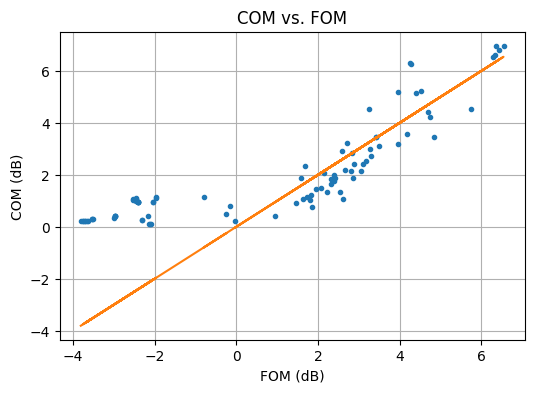

In [13]:
fom = np.array(list(map(lambda tup: tup[2], com_rslts)))
plt.figure(figsize=(6, 4))
plt.plot(fom, com_vals, ".")
plt.plot(fom, fom + 0.0)
plt.title("COM vs. FOM")
plt.xlabel("FOM (dB)")
plt.ylabel("COM (dB)")
plt.grid()
plt.show()


There seems to be pretty good correlation between COM and FOM, above zero.  
And the range of FOM values is consistent w/ Adam's plots of COM values.  
However, the COM values appear to be bounded from below by zero, which is incorrect.

### Tabulated Results

The tabulated results below suggest the following:

1. The COM & FOM values agree fairly well, both with each other and Adam's reported range of values for these channels, for _positive_ values of both.
However, the agreement falls apart for negative FOM values.
Indeed, the COM values seem to be bounded from below by zero.
And that is incorrect.

    - The range of COM values in Adam's plots is about: [-3, 6].
    - Note the FOM numbers, below, fit into that range quite nicely.
  
3. The other noise components are dwarfed by `Sigma_ISI`.

    - The next largest component, `Sigma_Tx`, is down by an order of magnitude!
    - The rest barely even register; why?


In [5]:
print("All 'Sigma_?' values have units of mV.")
print("\nGroup\tChannel\t\t\t\t\t  COM (dB)   FOM (dB)    ME (mV)   As (mV)  Ani (mV)  Sigma_Tx\t Sigma_ISI   Sigma_J\tSigma_Xt   Sigma_N")
print("=" * 154)
for grp in theCOMs.keys():
    print(grp)
    for lbl in theCOMs[grp].keys():
        print(f"\t{lbl[-40:]:41s}", end="")
        com  = theCOMs[grp][lbl]
        print(f"  {com.com:4.1f}       {com.fom:4.1f}        {np.sqrt(com.mse) * 1e3:.1g}   {com.As * 1e3:7.1f}   {com.Ani * 1e3:7.1f}     {com.com_sigma_Tx * 1e3:4.2f}\t   {com.com_sigma_ISI * 1e3:4.2f}      {com.sigma_J * 1e3:4.2f}\t  {com.sigma_XT * 1e3:4.2f}       {com.com_sigma_N * 1e3:4.2f}")


All 'Sigma_?' values have units of mV.

Group	Channel					  COM (dB)   FOM (dB)    ME (mV)   As (mV)  Ani (mV)  Sigma_Tx	 Sigma_ISI   Sigma_J	Sigma_Xt   Sigma_N
mellitz_3dj_02_elec_230504
	CB-25-25_mm_FO-100-100_mm_CA-500_mm_thru    4.4        4.7        2e+02     985.9     592.5     22.07	   171.86      1.17	  0.50       0.61
	CB-50-50_mm_FO-100-100_mm_CA-500_mm_thru    1.2        1.7        3e+02    1028.7     900.2     23.03	   275.22      1.01	  0.37       0.61
	CB-75-75_mm_FO-100-100_mm_CA-500_mm_thru    2.3        1.7        3e+02     857.0     655.6     19.19	   214.00      0.84	  0.29       0.61
	CB-25-25_mm_FO-200-200_mm_CA-500_mm_thru    0.7        1.9        3e+02     968.0     888.6     21.67	   270.30      1.01	  0.38       0.61
	CB-50-50_mm_FO-200-200_mm_CA-500_mm_thru    2.0        2.4        3e+02    1001.4     795.1     22.42	   237.46      0.82	  0.28       0.61
	CB-75-75_mm_FO-200-200_mm_CA-500_mm_thru    3.2        2.7        2e+02     863.0     595.5     19.32	   1

### Noise & Interf. PMF Plots

Let's plot the various components of `py` and see if anything suspicious shows up...


            mellitz_3dj_02_elec_230504              mellitz_3dj_03_elec_230504                 shanbhag_3dj_02_2305                     weaver_3dj_02_2305           

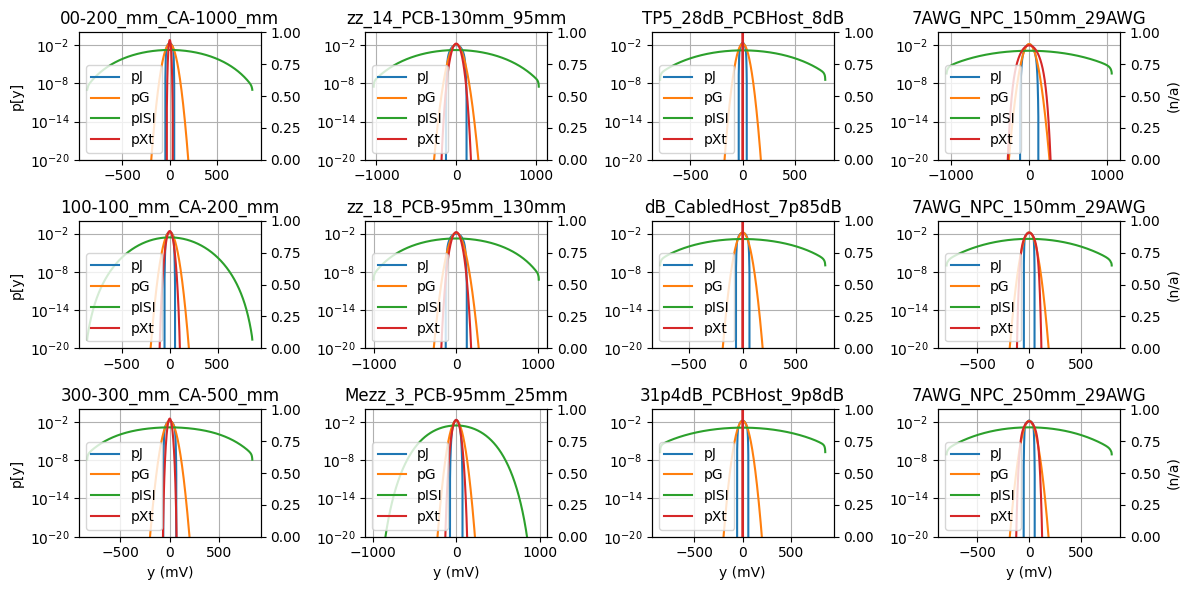

In [92]:
def plot_pys(com: COM, grp: str, lbl: str, nm: str, clr: str, ax1: Any, ax2: Any) -> None:
    """
    Plot various components of the noise & interference PMF.

    Args:
        com: The COM object to use for plotting.
        grp: The channel _group_ name.
        lbl: The channel _set_ name.
        nm: The COM group _name_ (i.e. - "MMSE" vs. "PRZF", for instance).
        clr: The name of the _color_ to use for plotting.
        ax1: Primary y-axis.
        ax2: Secondary y-axis.

    Returns:
        None

    Notes:
        1. The calling signature of this function is defined by the `plot_group_samps()` function.
            (See the _Imports & Utilities_ section, above.)
    """

    y = com.rslts["y"]
    ax1.semilogy(y * 1e3, com.dbg['pJ'],    label="pJ")
    ax1.semilogy(y * 1e3, com.rslts['pG'],  label="pG")
    ax1.semilogy(y * 1e3, com.rslts['py0'], label="pISI")
    pk = com.pks[0]
    for _pk in com.pks[1:]:
        pk = np.convolve(pk, _pk, mode="same")
    ax1.semilogy(y * 1e3, pk, label="pXt")
    ax1.axis(ymin=1e-20, ymax=1)
    ax1.grid()
    ax1.legend(loc="lower left")
    plt.title(f"{lbl[-25: -5]}")

plot_group_samps(plot_pys, "y (mV)", ("p[y]", "(n/a)"), [("MMSE", "blue", theCOMs),])


The ISI is just too extreme.
At 1e-4 (our DER0), we're already out about 500 mV!
That's too much.
Something must be wrong w/ the ISI calculation.

### Power Spectral Density Plots

In the new MMSE approach to Rx FFE tap weight optimization, the noise and interference _power spectral densities_ (PSDs) play a primary role.  
Let's plot them and see if anything suspicious shows up...


            mellitz_3dj_02_elec_230504              mellitz_3dj_03_elec_230504                 shanbhag_3dj_02_2305          

AssertionError: Length of input (22000) must match length of `t_irfft` vector (16000)!

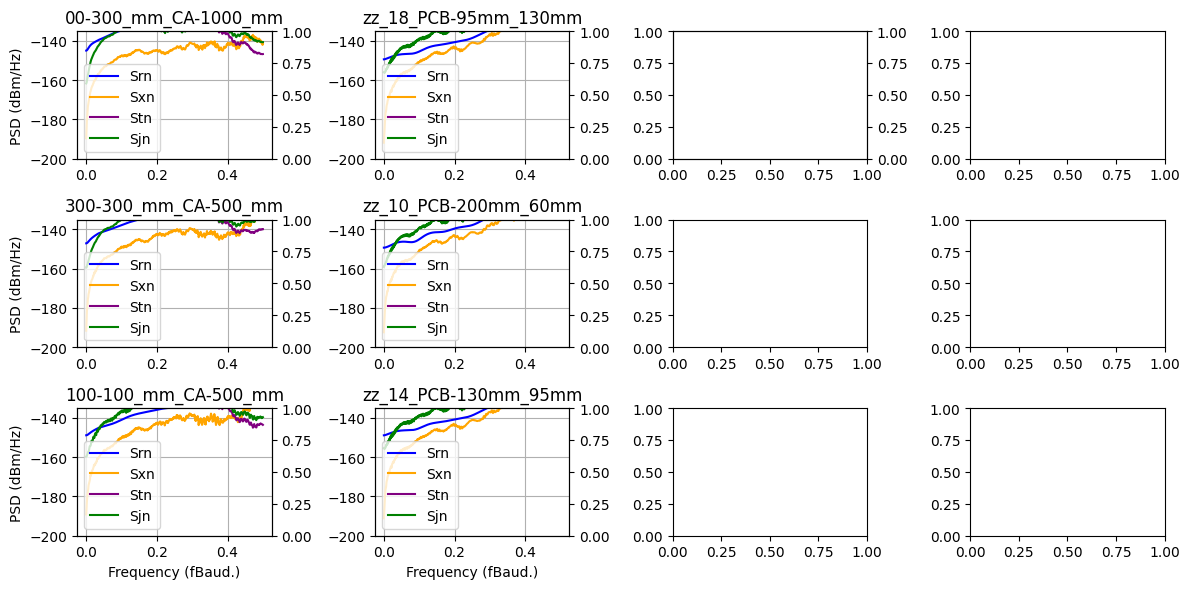

In [99]:
def plot_psds(com: COM, grp: str, lbl: str, nm: str, clr: str, ax1: Any, ax2: Any) -> None:
    "Plot various components of the noise & interference PSD."
    theNoiseCalc = com.theNoiseCalc
    Srn = theNoiseCalc.Srn
    Sxn = np.sum(np.array(list(map(theNoiseCalc.Sxn, theNoiseCalc.agg_pulse_resps))), axis=0)
    Stn = theNoiseCalc.Stn
    Sjn = theNoiseCalc.Sjn

    Hffe = calc_Hffe(np.array(com.rx_taps).flatten(), com.nRxTaps - com.nRxPreTaps - 1, isRx=True)
    # _Hffe_2 = np.abs(Hffe) ** 2
    # rslt  = self.eta0 * 1e-9 * abs(self.Hr * self.Hctf) ** 2  # "/ 2" in [1] omitted, since we're only considering: m >= 0.
    Hffe_2 = abs(rfft(theNoiseCalc.from_irfft(irfft(np.abs(Hffe) ** 2))))  # * 2 * theNoiseCalc.f[-1] * theNoiseCalc.Tb
    
    _f = np.linspace(0, 0.5, len(Srn))
    ax1.plot(_f, dBm_Hz(Srn * Hffe_2), label="Srn", color="blue")
    ax1.plot(_f, dBm_Hz(Sxn * Hffe_2), label="Sxn", color="orange")
    ax1.plot(_f, dBm_Hz(Stn * Hffe_2), label="Stn", color="purple")
    ax1.plot(_f, dBm_Hz(Sjn * Hffe_2), label="Sjn", color="green")
    plt.title(f"{grp[:12]}:{lbl[-15:]}")

    ax1.axis(ymin=-200, ymax=-135)
    ax1.grid()
    ax1.legend(loc="lower left")
    plt.title(f"{lbl[-25: -5]}")

plot_group_samps(plot_psds, "Frequency (fBaud.)", ("PSD (dBm/Hz)", "(n/a)"), [("MMSE", "blue", theCOMs),])


### Lambda vs. MSE/varX

The Lagrange multiplier value, $\lambda$, from the MMSE matrix equation solution for the optimum Rx FFE tap weights is supposed to equal the _minimum mean squared error_ (MMSE) normalized to the average signal power, $\sigma_X^2$.  
Let's see if that holds true...

In [15]:
print("\nGroup\tChannel\t\t\t\t\t   Lambda     MSE/varX    Hit b limit")
print("=" * 85)
for grp in theCOMs.keys():
    print(grp)
    for lbl in list(theCOMs[grp].keys())[:3]:
        print(f"\t{lbl[-40:]:41s}", end="")
        com  = theCOMs[grp][lbl]
        L = com.L
        varX = (L**2 - 1) / (3 * (L - 1)**2)  # (93A-29)
        print(f"   {com.mmse_rslt['lambda']:5.3f}\t{com.mse / varX:5.3f}\t    {com.mmse_rslt['hit_b_limit']}")



Group	Channel					   Lambda     MSE/varX    Hit b limit
mellitz_3dj_02_elec_230504
	CB-25-25_mm_FO-100-100_mm_CA-500_mm_thru    0.032	0.068	    False
	CB-50-50_mm_FO-100-100_mm_CA-500_mm_thru    0.029	0.134	    False
	CB-75-75_mm_FO-100-100_mm_CA-500_mm_thru    0.029	0.136	    False
mellitz_3dj_03_elec_230504
	2C_withXtalk_Mezz_10_PCB-200mm_60mm_thru    0.023	0.103	    False
	C2C_withXtalk_Mezz_11_PCB-25mm_95mm_thru    0.026	0.045	    False
	C2C_withXtalk_Mezz_12_PCB-60mm_95mm_thru    0.034	0.075	    False
shanbhag_3dj_02_2305
	abledBP_TP0TP5_19p3dB_PCBHost_3p8dB_THRU    0.032	0.143	    False
	dBP_TP0TP5_27p4dB_CabledHost_7p85dB_THRU    0.039	0.207	    False
	_1mCabledBP_TP0TP5_28dB_PCBHost_8dB_THRU    0.049	0.241	    False
weaver_3dj_02_2305
	9AWG_BP_800mm_27AWG_NPC_150mm_29AWG_thru    0.137	0.330	    False
	9AWG_BP_800mm_27AWG_NPC_200mm_29AWG_thru    0.141	0.340	    False
	9AWG_BP_800mm_27AWG_NPC_250mm_29AWG_thru    0.134	0.324	    False


That large difference between `Lambda` and `MSE/varX` is suspicious.  
Adam claims that they should be roughly equal.

**ToDo:** Check for `w` limit hits.

### Histogram of Intermediate Results

As a sanity check on our runs, we plot the histograms of some important intermediate results below.

**Note:** The _Bandwidth_ refers to the raw interconnect, while the _Reflectivity_ includes the effect of the package, but not the equalization.

In [9]:
names     = []
com_vals  = []
com_rslts = []
for grp, d in theCOMs.items():
    for lbl, theCOM in d.items():
        names.append(grp + ":" + lbl)
        com_vals.append(theCOM.rslts['com'])
        com_rslts.append([
            theCOM.rslts['As'],
            theCOM.rslts['Ani'],
            theCOM.rslts['fom'],
            theCOM.rslts['sigma_ISI'],
            theCOM.rslts['sigma_XT'],
            theCOM.rslts['sigma_J'],
            theCOM.rslts['sigma_G'],
            theCOM.rslts['sigma_Tx'],
            theCOM.rslts['sigma_N'],
            1 / (fwhm(theCOM.pulse_resps_nopkg[0]) * theCOM.times[1]),  # raw channel bandwidth
            reflectivity(theCOM.pulse_resps_noeq[0]) * theCOM.times[1],
        ])


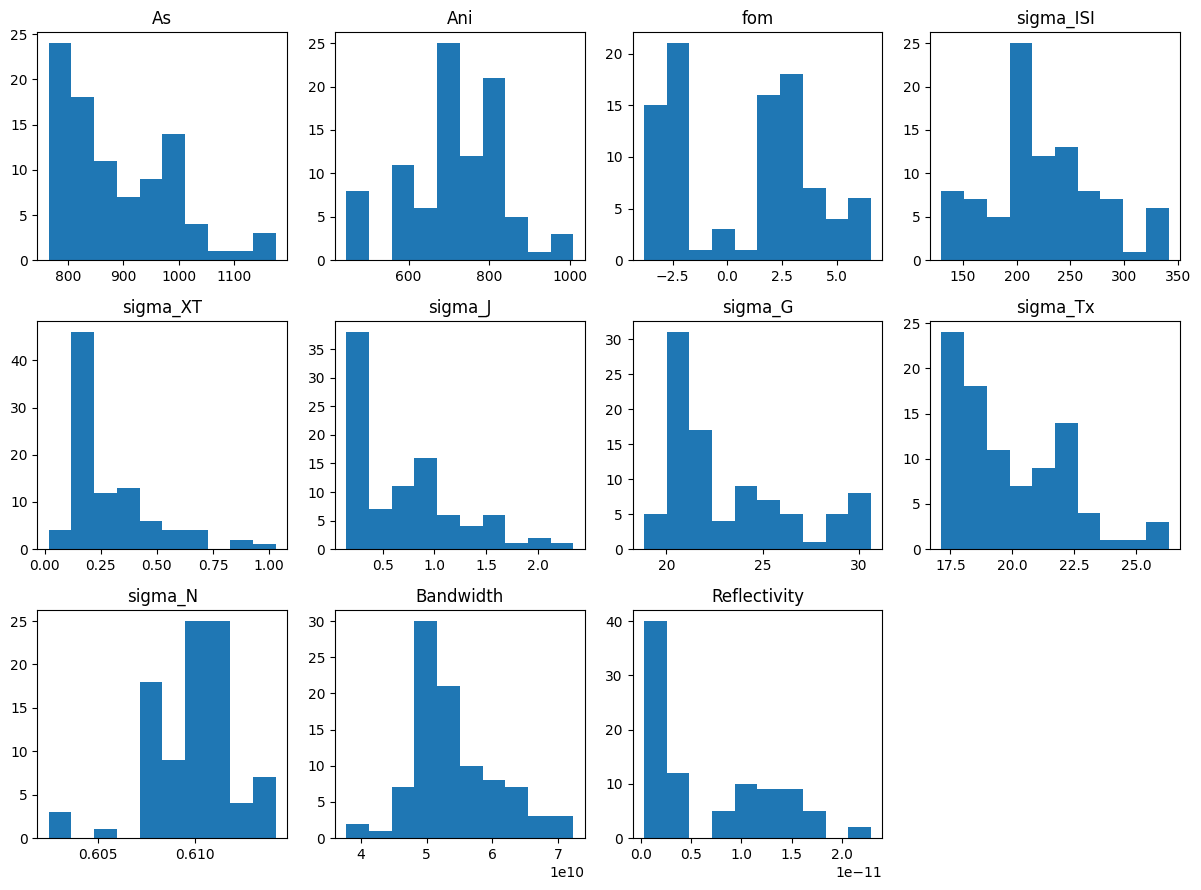

In [10]:
plt.figure(figsize=(12, 9))
labels = ["As", "Ani", "fom", "sigma_ISI", "sigma_XT", "sigma_J", "sigma_G", "sigma_Tx", "sigma_N", "Bandwidth", "Reflectivity"]
for ix, (label, values) in enumerate(zip(labels, np.array(com_rslts).T)):
    plt.subplot(3, 4, 1 + ix)
    plt.hist(values)
    plt.title(label)
plt.tight_layout()
plt.show()


### Random Sampling of Equalized Pulse Responses

As a further sanity check on the results, below are plotted the equalized pulse responses for 12 randomly selected cases.

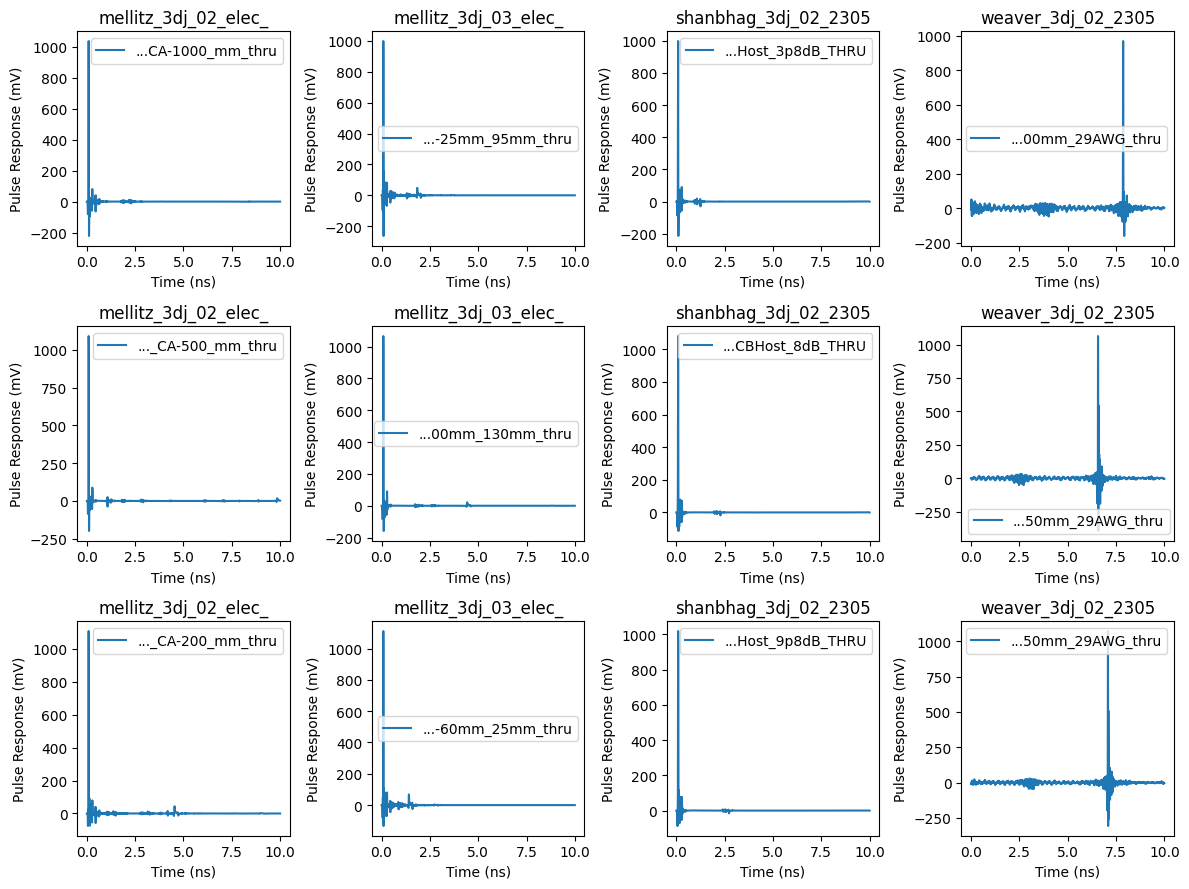

In [11]:
plt.figure(figsize=(12, 9))
labeled_coms_by_group = [
    (grp, theCOMs[grp].items())
    for grp in theCOMs.keys()
]
for ix in range(12):
    grp, coms = labeled_coms_by_group[ix % len(labeled_coms_by_group)]
    lbl, com = choice(list(coms))
    plt.subplot(3, 4, 1 + ix)
    plt.plot(com.times * 1e9, com.pulse_resps[0] * 1e3, label=f"...{lbl[-15:]}")
    plt.title(grp[:20])
    plt.xlabel("Time (ns)")
    plt.ylabel("Pulse Response (mV)")
    # plt.axis(xmin=0, xmax=10, ymin=-10, ymax=100)
    plt.legend()
plt.tight_layout()
plt.show()


## PRZF vs. MMSE

Let's compare the old _Pulse Response Zero Forcing_ (PRZF) method of EQ optimization to the new _Minimum Mean Squared Error_ (MMSE) method, to see if we can flush out any bugs in the new (or, old) approach.


### FOM Comparison

The FOM values above seem to be consistent w/ Adam's reported COM numbers.    
Let's compare the old vs. new FOM calculations for a few randomly chosen channels,  
which we'll re-run in PRZF mode, so we can compare results.

In [47]:
_theCOMs = run_com(sample(tested_ch_sets, 9), params, opt_mode=OptMode.PRZF)


In [48]:
print("Data pairs are: (PRZF) / (MMSE).")
print("All 'Sigma_?' values in (mV).")
print("\nGroup\tChannel\t\t\t\t\t     FOM (dB)       Ani (mV)\t  RMSE (mV)\t  Sigma_Tx\t    Sigma_J\t    Sigma_Xt\t    Sigma_N\t     Sigma_ISI")
print("=" * 175)
for grp in _theCOMs.keys():
    print(grp)
    for lbl in _theCOMs[grp].keys():
        print(f"\t{lbl[-40:]:41s}", end="")
        _com = _theCOMs[grp][lbl]
        com  = theCOMs[grp][lbl]
        print(f"  {_com.fom:4.1f} / {com.fom:4.1f}   {_com.Ani * 1e3:5.1f} / {com.Ani * 1e3:5.1f}    {np.sqrt(_com.mse) * 1e3:1.0f} / {np.sqrt(com.mse) * 1e3:5.1f}", end="")
        print(f"   {_com.sigma_Tx * 1e3:6.2f} / {com.sigma_Tx * 1e3:6.2f}\t{_com.sigma_J * 1e3:6.2f} / {com.sigma_J * 1e3:6.2f}\t{_com.sigma_XT * 1e3:6.2f} / {com.sigma_XT * 1e3:6.2f}\t", end="")
        print(f"{_com.sigma_N * 1e3:6.2f} / {com.sigma_N * 1e3:6.2f}\t     {_com.sigma_ISI * 1e3:6.2f} / {com.sigma_ISI * 1e3:1.0f}")


Data pairs are: (PRZF) / (MMSE).
All 'Sigma_?' values in (mV).

Group	Channel					     FOM (dB)       Ani (mV)	  RMSE (mV)	  Sigma_Tx	    Sigma_J	    Sigma_Xt	    Sigma_N	     Sigma_ISI
weaver_3dj_02_2305
	9AWG_BP_800mm_27AWG_NPC_150mm_29AWG_thru   11.5 / -2.3   509.0 / 959.4    0 / 434.5    17.97 /   1.87	 17.08 /   0.27	 19.32 /   0.22	  0.61 /   0.61	     265.22 / 0
	9AWG_BP_800mm_27AWG_NPC_400mm_29AWG_thru    9.3 / -3.0   593.3 / 762.0    0 / 469.4    17.52 /   1.52	 21.02 /   0.20	 27.29 /   0.21	  0.61 /   0.61	     340.74 / 0
	9AWG_BP_800mm_27AWG_NPC_300mm_29AWG_thru    8.2 / -3.5   690.2 / 797.0    0 / 500.6    17.95 /   1.31	 17.95 /   0.17	 31.36 /   0.21	  0.61 /   0.61	     386.42 / 0
	9AWG_BP_800mm_27AWG_NPC_400mm_29AWG_thru    8.9 / -3.7   592.8 / 813.8    0 / 511.1    18.23 /   1.46	 17.17 /   0.19	 28.88 /   0.21	  0.61 /   0.61	     355.92 / 0
	9AWG_BP_800mm_27AWG_NPC_150mm_29AWG_thru   10.4 / -2.4   525.3 / 712.1    0 / 440.0    19.25 /   1.61	 24.70 /   0.22	 30.20 /

**Observations:**

1. The PRZF FOM values are much higher than their MMSE equivalents and somewhat consistent w/ the MMSE COM values above.
    - This is quite strange, given that the `Ani` values are quite similar in all but one of the cases.
    - This is also completely inconsistent w/ the noise numbers, which are substantially lower in the MMSE case!
    (Note that the `Sigma_ISI` value is set to zero by the code, in the MMSE case.)

        - How is that possible, given the FOM value comparisons?!
            - Well, in the MMSE case, the FOM value calculation doesn't involve the noise sigma values directly:
               
                ```python
                mse = varX * (w_lim @ R @ w_lim.T + 1 + b_lim @ b_lim - 2 * w_lim @ h0 - 2 * w_lim @ Hb.T @ b_lim).flatten()[0]
                fom = 20 * log10(Rlm / (L - 1) / sqrt(mse))
                ```  

            - So, perhaps, there's a disconnect between `R` and the various sigma noise values, or the equation for `mse` is wrong?
         
The `R` matrix is built from the `Rn` vector coming from the `NoiseCalc` instance.  
And that `Rn` vector is calculated by IFFT'ing a summation of the _power spectral densities_ (PSDs):

```python
def Rn(self) -> Rvec:
    """Noise autocorrelation vector at Rx FFE input."""
    Sn = self.Srn + sum(array(list(map(self.Sxn, self.agg_pulse_resps))), axis=0) + self.Stn + self.Sjn
    return irfft(Sn) / self.Tb  # i.e. - `* fB`, which when combined w/ the implicit `1/N` of `irfft()` yields `* df`.
```
==> Okay, let's plot those PSDs and see what's going on...

#### Power Spectral Density

Here, we plot the noise PSDs used to calculate `Rn`.
(See the discussion above.)

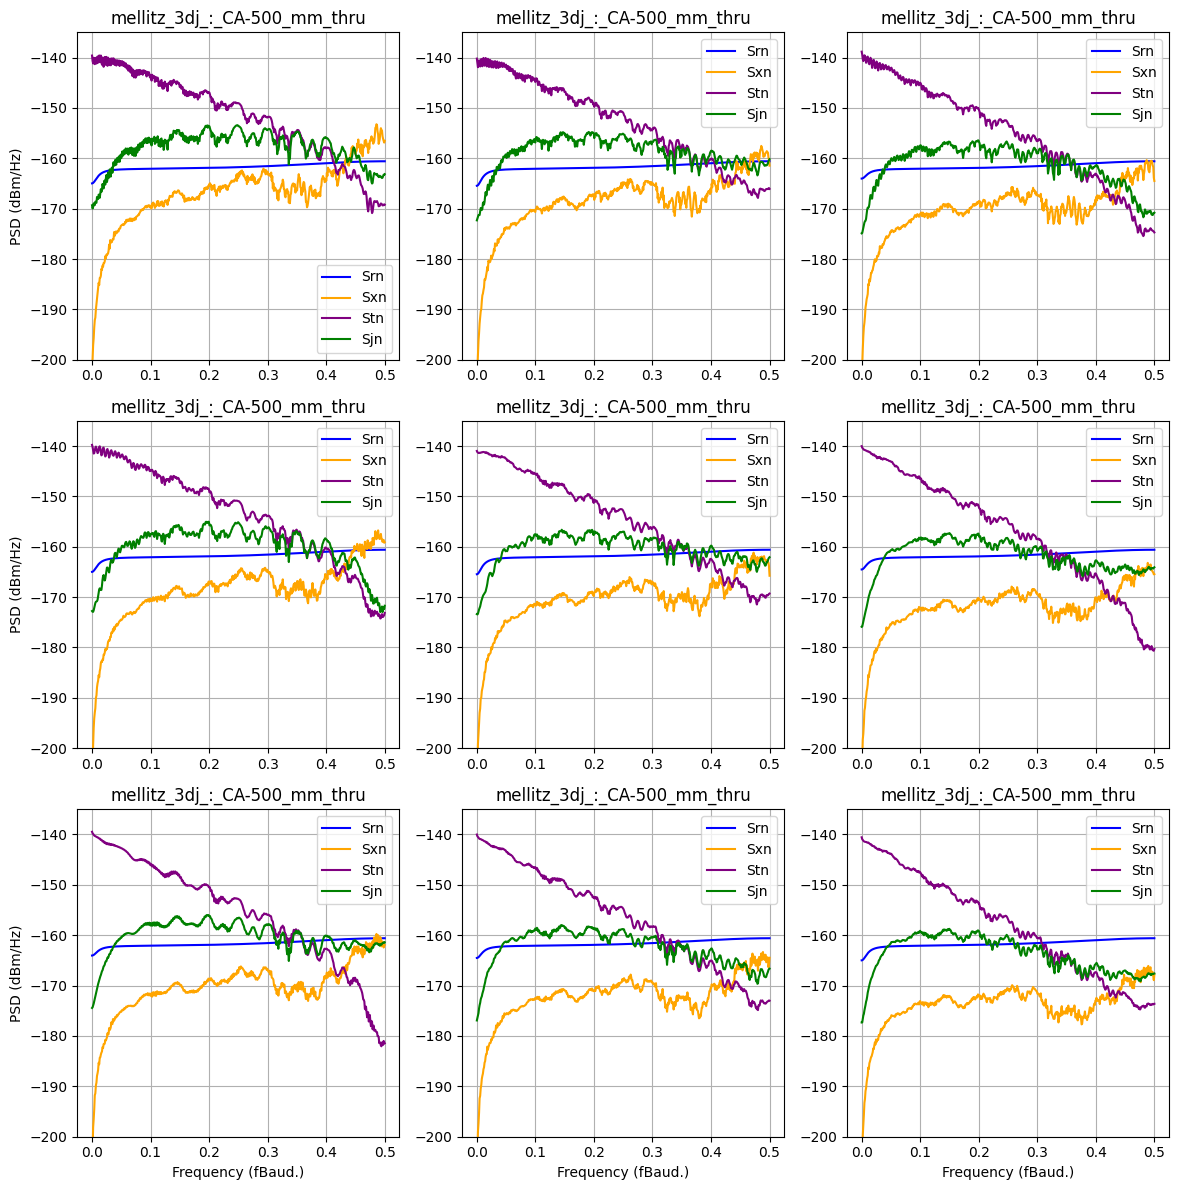

In [93]:
plt.figure(figsize=(12, 12))
n = 1
for grp in theCOMs.keys():
    for lbl in theCOMs[grp].keys():
        com  = theCOMs[grp][lbl]
        theNoiseCalc = com.theNoiseCalc
        Srn = theNoiseCalc.Srn
        Sxn = np.sum(np.array(list(map(theNoiseCalc.Sxn, theNoiseCalc.agg_pulse_resps))), axis=0)
        Stn = theNoiseCalc.Stn
        Sjn = theNoiseCalc.Sjn

        plt.subplot(330 + n)
        plt.tight_layout()
        _f = np.linspace(0, 0.5, len(Srn))
        plt.plot(_f, dBm_Hz(Srn), label="Srn", color="blue")
        plt.plot(_f, dBm_Hz(Sxn), label="Sxn", color="orange")
        plt.plot(_f, dBm_Hz(Stn), label="Stn", color="purple")
        plt.plot(_f, dBm_Hz(Sjn), label="Sjn", color="green")
        plt.title(f"{grp[:12]}:{lbl[-15:]}")
        if n > 6:
            plt.xlabel("Frequency (fBaud.)")
        if n % 3 == 1:
            plt.ylabel("PSD (dBm/Hz)")
        plt.axis(ymin=-200, ymax=-135)
        plt.grid()
        plt.legend()
        n += 1
        if n > 9:
            break
    if n > 9:
        break
plt.show()


Well, those all seem to be, at least, in the same order of magnitude range as what Adam Healey reported in his January 2024 presentation to the 802.3dj task force:

![Adam Healey's PSD Plots](Adams_PSDs.png)


#### Autocorrelation Vectors

As a final check, let's plot the `Rn` for the test cases above.

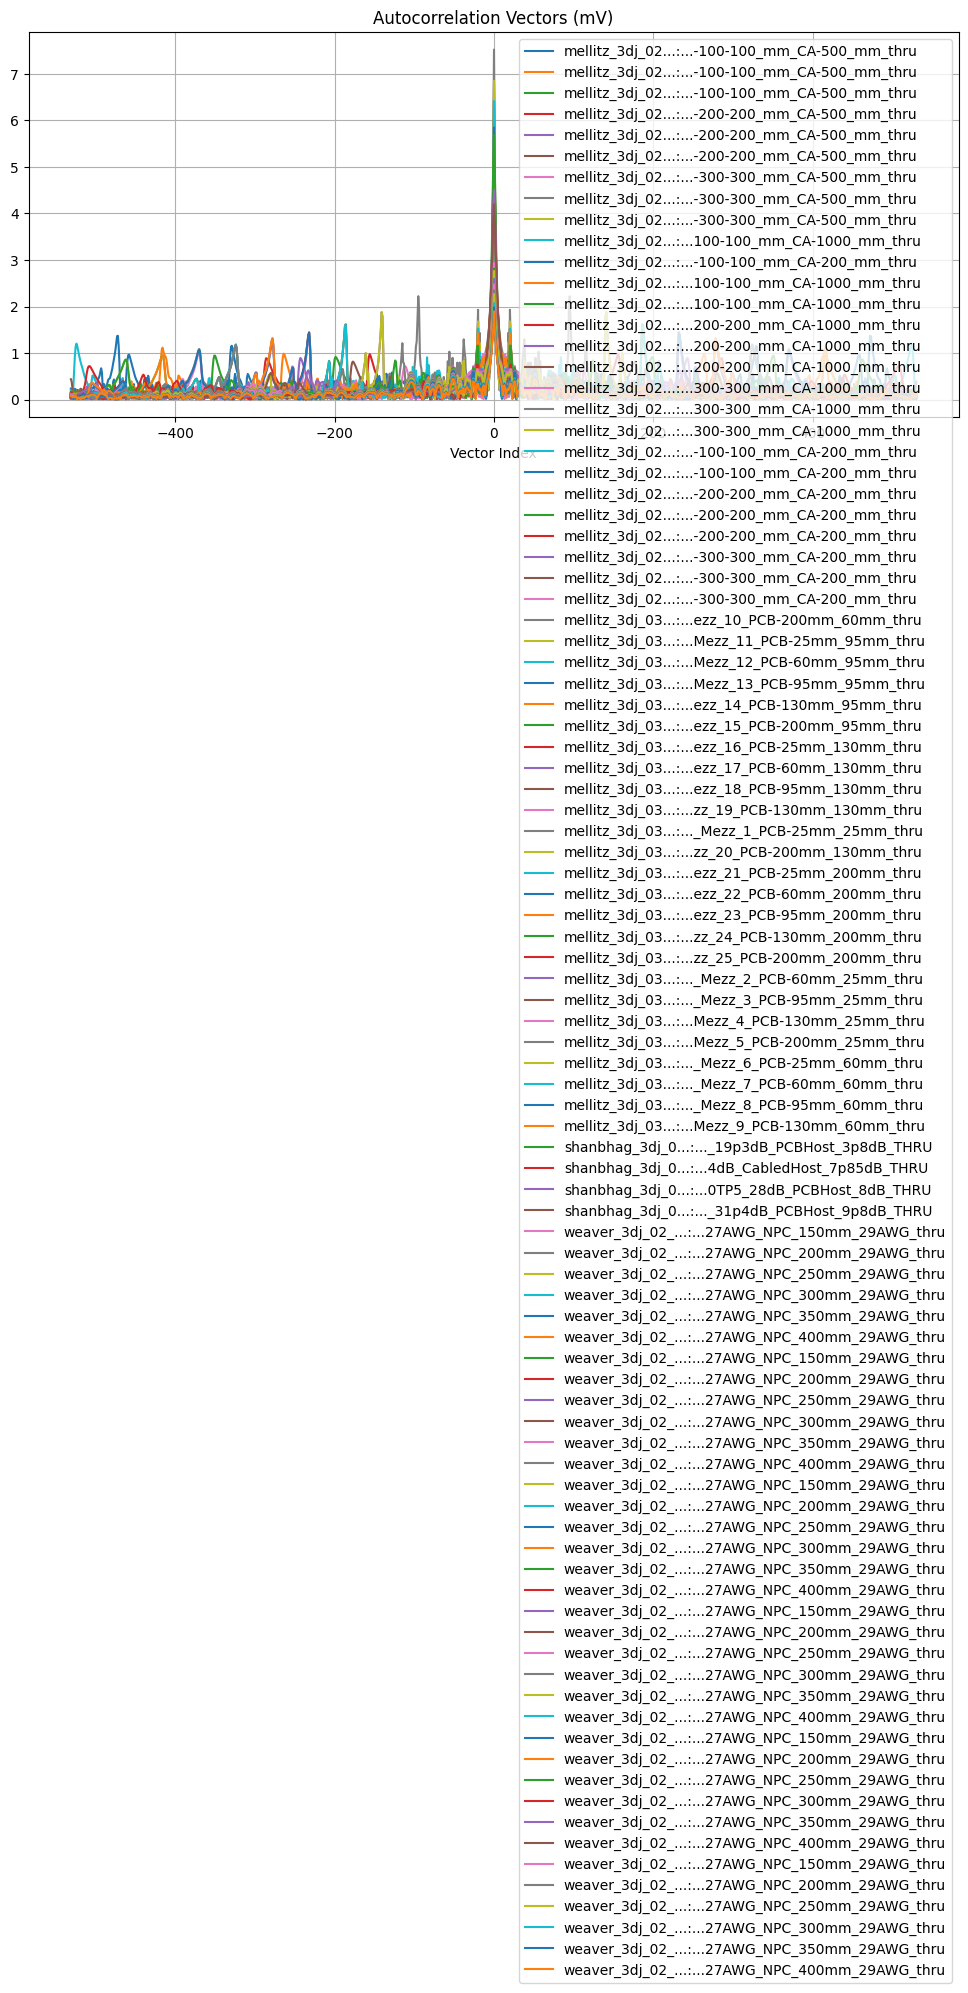

In [50]:
plt.figure(figsize=(12, 5))
for grp in theCOMs.keys():
    for lbl in theCOMs[grp].keys():
        com  = theCOMs[grp][lbl]
        theNoiseCalc = com.theNoiseCalc
        Rn = np.abs(theNoiseCalc.Rn())
        assert all(Rn >= 0)
        assert not any(np.isnan(Rn))
        ix = np.arange(len(Rn)) - len(Rn) // 2
        plt.plot(ix, fftshift(np.sqrt(Rn)) * 1e3, label=grp[:14]+"...:..."+lbl[-26:])
plt.title("Autocorrelation Vectors (mV)")
plt.xlabel("Vector Index")
# plt.axis(ymin=-200, ymax=-135)
plt.grid()
plt.legend()
plt.show()


Well, those certainly look like autocorrelation vectors, but I don't really know how to judge whether the magnitude makes sense.
Let's generate their noise PDFs and look at those...

#### Rn PDFs

Here, we use the autocorrelation vectors above to generate noise PDFs, just like in the COM calculation for $A_{ni}$.

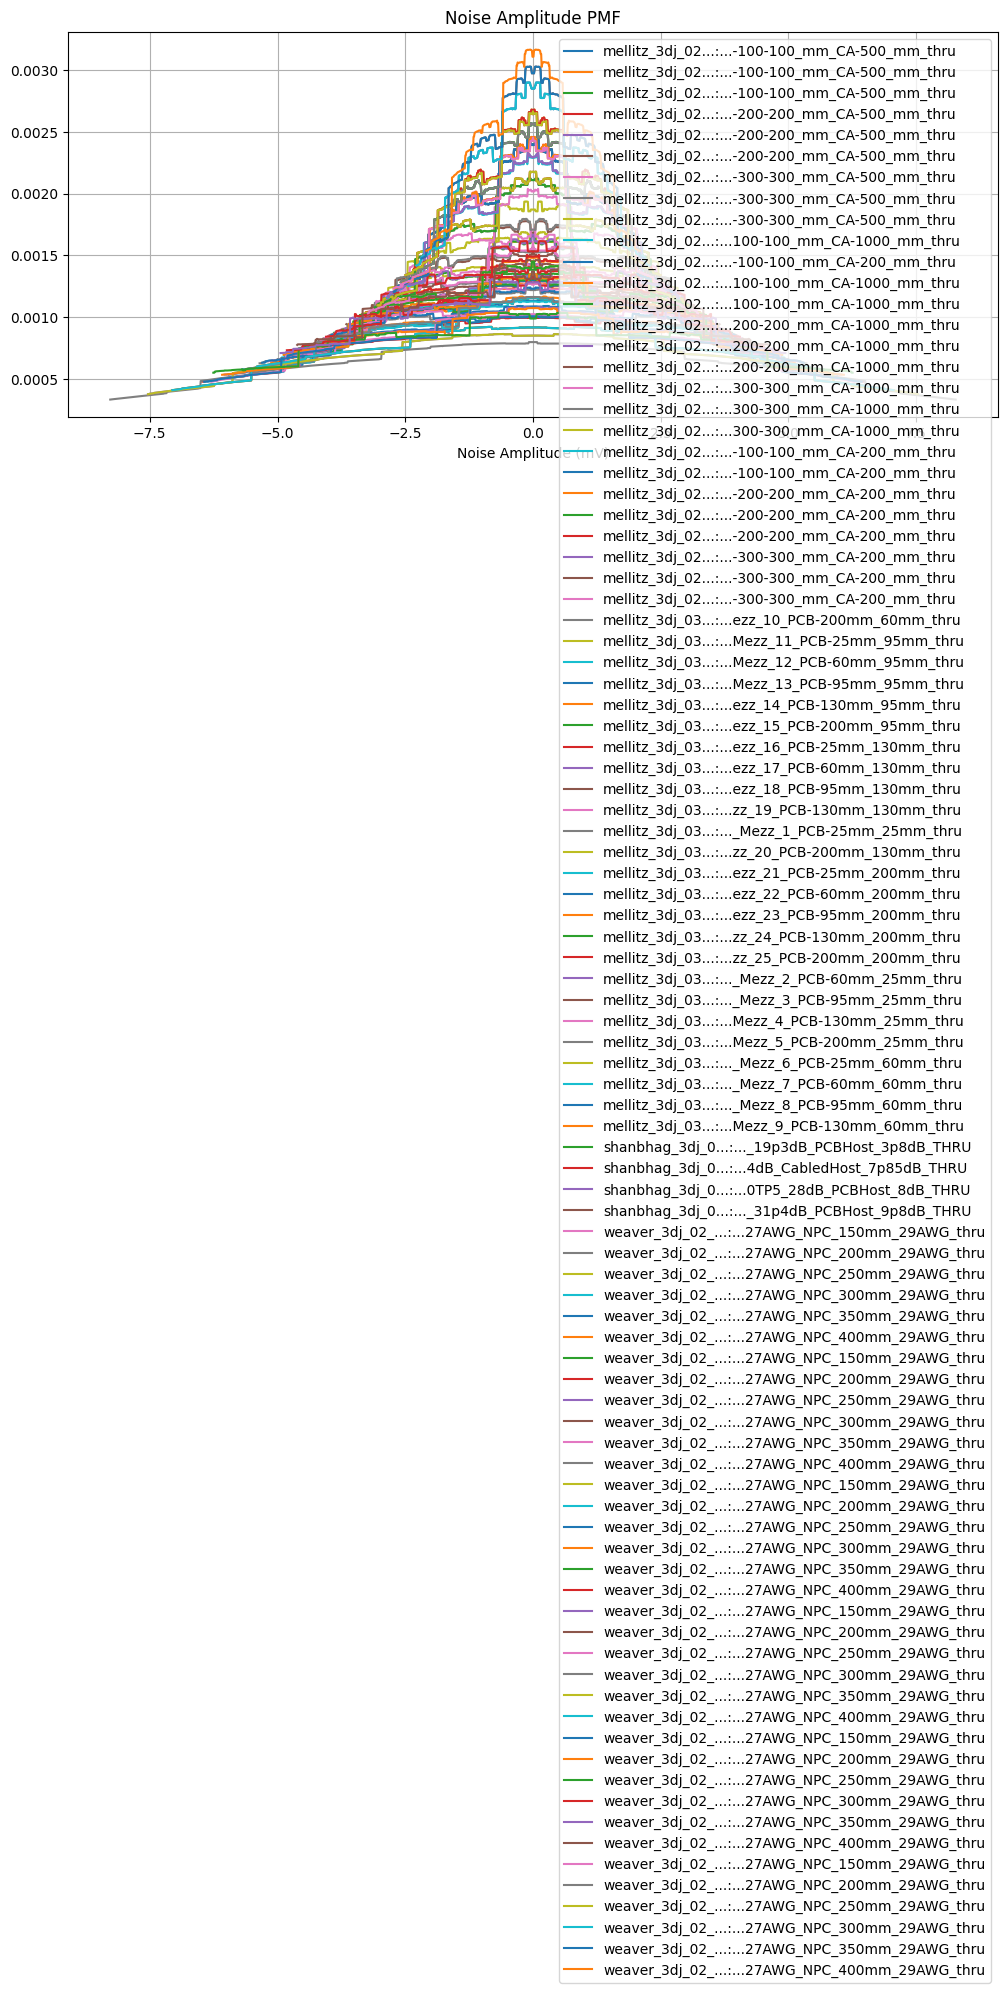

In [51]:
from pychopmarg.utility import delta_pmf

plt.figure(figsize=(12, 5))
for grp in theCOMs.keys():
    for lbl in theCOMs[grp].keys():
        com = theCOMs[grp][lbl]
        theNoiseCalc = com.theNoiseCalc
        x, py = delta_pmf(np.sqrt(np.abs(theNoiseCalc.Rn())))
        plt.plot(x * 1e3, py, label=grp[:14]+"...:..."+lbl[-26:])
plt.title("Noise Amplitude PMF")
plt.xlabel("Noise Amplitude (mV)")
plt.grid()
plt.legend()
plt.show()


### Pulse Response Comparison

Let's plot the victim pulse response and compare.  
We'll include the ISI for the MMSE case, as a visual indicator of the quality of the Rx FFE tap weight optimization process.

hISI samples shown as 'x's.


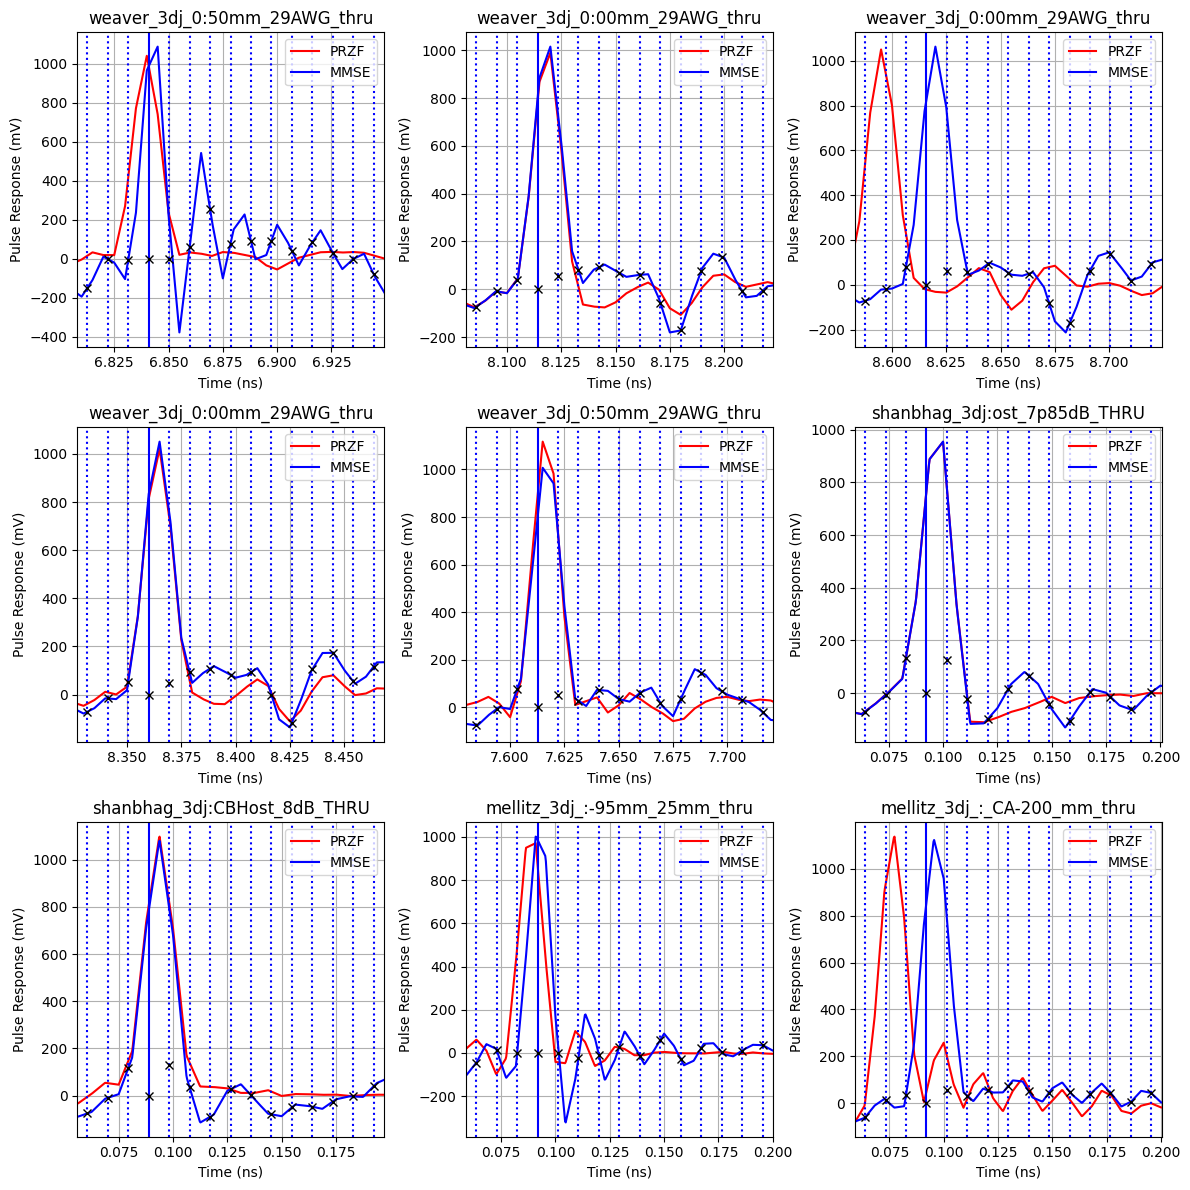

In [52]:
print("hISI samples shown as 'x's.")
plt.figure(figsize=(12, 12))
n = 1
for grp in _theCOMs.keys():
    for lbl in _theCOMs[grp].keys():
        _com = _theCOMs[grp][lbl]
        com  = theCOMs[grp][lbl]
        ui = 1 / com.fb
        curs_ix = com.com_cursor_ix
        nspui = com.nspui
        first_ix = curs_ix - com.nRxPreTaps * nspui
        last_ix = first_ix + com.nRxTaps * nspui
        ix_isi = range(first_ix, last_ix, nspui)
        plt.subplot(330 + n)
        plt.tight_layout()
        plt.plot(_com.times * 1e9, _com.pulse_resps[0] * 1e3, label="PRZF", color="red")
        plt.plot(com.times * 1e9, com.pulse_resps[0] * 1e3, label="MMSE", color="blue")
        for _n, _ix in enumerate(ix_isi):
            _t = com.times[_ix]
            if _n == com.nRxPreTaps:  # cursor
                plt.axvline(_t * 1e9, color="blue", linestyle="-")
            else:
                plt.axvline(_t * 1e9, color="blue", linestyle=":")
        plt.plot(com.com_tISI * 1e9, com.com_hISI * 1e3, "xk")
        plt.title(f"{grp[:12]}:{lbl[-15:]}")
        plt.xlabel("Time (ns)")
        plt.ylabel("Pulse Response (mV)")
        plt.axis(xmin=(com.times[first_ix] - ui/2) * 1e9, xmax=(com.times[last_ix] - ui/2) * 1e9)
        plt.grid()
        plt.legend()
        n += 1
        if n > 9:
            break
plt.show()


### Rx FFE Tap Weight Comparison

Let's compare the Rx FFE tap weights...

Final Rx FFE Tap Weights (solid) and pre-FFE Pulse Response (dotted):


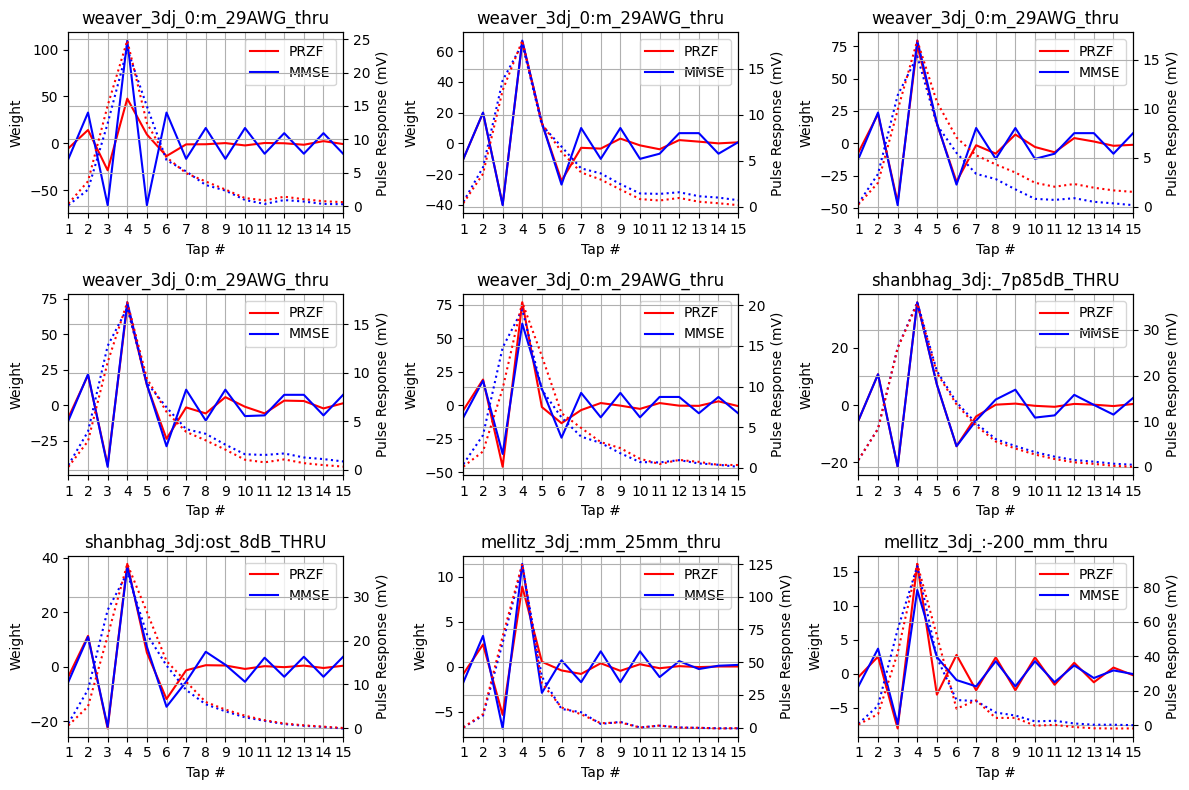

In [78]:
from matplotlib.ticker import MultipleLocator
print("Final Rx FFE Tap Weights (solid) and pre-FFE Pulse Response (dotted):")
fig, axs = plt.subplots(3, 3, figsize=(12, 8))
n = 0
for grp in _theCOMs.keys():
    for lbl in _theCOMs[grp].keys():
        _com = _theCOMs[grp][lbl]
        com  = theCOMs[grp][lbl]
        nTaps = len(_com.rx_taps)
        nPreTaps = 3
        tap_ix = np.arange(nTaps) + 1
        row, col = divmod(n, 3)
        ax1 = axs[row][col]
        ax2 = ax1.twinx()
        plt.tight_layout()
        ax1.plot(tap_ix, _com.rx_taps, label="PRZF", color="red")
        ax1.plot(tap_ix,  com.rx_taps, label="MMSE", color="blue")
        pr_samps = com.pr_samps
        curs_loc = np.argmax(pr_samps)
        pr_samps = pr_samps[curs_loc - nPreTaps: curs_loc - nPreTaps + nTaps]
        ax2.plot(tap_ix, pr_samps * 1e3, ":", color="blue")
        _pr_samps = _com.pr_samps
        _curs_loc = np.argmax(_pr_samps)
        _pr_samps = _pr_samps[_curs_loc - nPreTaps: _curs_loc - nPreTaps + nTaps]
        ax2.plot(tap_ix, _pr_samps * 1e3, ":", color="red")
        plt.title(f"{grp[:12]}:{lbl[-12:]}")
        ax1.set_xlabel("Tap #")
        ax1.set_ylabel("Weight")
        ax2.set_ylabel("Pulse Response (mV)")
        plt.axis(xmin=1, xmax=15)
        ax1.xaxis.set_major_locator(MultipleLocator(1))
        ax1.grid(which='major', axis='x')
        ax2.grid(which='major', axis='y')
        ax1.legend()
        n += 1
        if n > 8:
            break
    if n > 8:
        break

plt.show()


## MATLAB vs. MMSE

Let's compare the MATLAB results to our MMSE results.
As per the request made in D1.2, we'll use the new v4.60 version of the M-code.


## Appendix A - Old Code

This appendix contains old code, preserved here for potential future use.

### ISI Investigation

Let's take a look at the ISI and see why it's so high.

In [ ]:
plt.figure(figsize=(12, 9))
labeled_coms_by_group = [
    (grp, theCOMs[grp].items())
    for grp in theCOMs.keys()
]
for ix in range(12):
    grp, coms = labeled_coms_by_group[ix % len(labeled_coms_by_group)]
    lbl, com = choice(list(coms))
    vic_pr = com.pulse_resps[0]
    _t_isi = com.com_tISI
    ui = 1 / com.fb
    plt.subplot(3, 4, 1 + ix)
    plt.plot(com.times * 1e9, vic_pr       * 1e3, label=f"...{lbl[-15:]}")
    plt.plot(_t_isi    * 1e9, com.com_hISI * 1e3, "x")
    plt.axvline(com.times[com.com_cursor_ix] * 1e9, linestyle=":")
    plt.title(grp[:20])
    if ix > 7:
        plt.xlabel("Time (ns)")
    if ix % 4 == 0:
        plt.ylabel("hISI (mV)")
    plt.axis(xmin = (_t_isi[0] - ui/2) * 1e9, xmax = (_t_isi[20] + ui/2) * 1e9)  # , ymin=-10, ymax=100)
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()


### Srn Debugging

Let's follow the process by which $S_{rn}$ is calculated and see if we can find the bug.

In [ ]:
com  = list(list(theCOMs.items())[0][1].items())[0][1]
theNoiseCalc = com.theNoiseCalc
assert np.array_equal(com.freqs, theNoiseCalc.f)
assert np.array_equal(com.times, theNoiseCalc.t)

f = theNoiseCalc.f
nspui = theNoiseCalc.nspui
t       = theNoiseCalc.t
t_irfft = theNoiseCalc.t_irfft
t_samp  = t[::nspui]
t_shift       = t - t[len(t) // 2]
t_irfft_shift = t_irfft - t_irfft[len(t_irfft) // 2]
t_samp_shift  = t_samp - t_samp[len(t_samp) // 2]
f_samp = np.linspace(0, 0.5 / t_samp[1], len(t_samp) // 2 + 1)

rslt  = theNoiseCalc.eta0 * 1e-9 * abs(theNoiseCalc.Hr * theNoiseCalc.Hctf) ** 2
rslt1 = irfft(rslt) * f[-1]             # When combined w/ the implicit 1/N of `irfft()`, yields: * df.
rslt2 = theNoiseCalc.from_irfft(rslt1)  # Interpolates to `t` and subsamples at fBaud.
rslt4 = abs(rfft(rslt2)) * t_samp[1] * 2

print(f"sum(rslt * df): {sum(rslt) * f[1]: .2e}; sum(rslt1): {sum(rslt1): .2e}; sum(rslt2): {sum(rslt2): .2e}; sum(rslt4 * dfsamp): {sum(rslt4) * f_samp[1]: .2e}")

plt.figure(figsize=(12, 4))

plot_f = f / 1e9
plt.subplot(121)
plt.plot(plot_f,       dBm_Hz(rslt),  label="$\_S_{rn}(f)$")
plt.plot(f_samp / 1e9, dBm_Hz(rslt4), label="$\_S_{rn}(\Theta)$")
plt.plot(f_samp / 1e9, dBm_Hz(theNoiseCalc.Srn), label="$S_{rn}(\Theta)$")
plt.title("Power Spectral Densities (dBm/Hz)")
plt.xlabel("Frequency (GHz)")
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(t_irfft_shift * 1e12, fftshift(np.sqrt(abs(rslt1))) * 1e3, label="$\_R(t)$")
plt.plot(t_samp_shift[:len(rslt2)]  * 1e12, fftshift(np.sqrt(abs(rslt2))) * 1e3, label="$\_R_n$")
plt.title("Autocorrelation Vectors (mV)")
plt.xlabel("Time (ps)")
plt.axis(xmin=-100, xmax=100)
plt.grid()
plt.legend()

plt.show()


The _Power Spectral Densities_ look exactly as expected, to wit:

- the sampled and actual values agree at d.c., and
- the sampled plot displays the aliasing we expect.

We fixed this bug, by:

- `fftshift()`ing the time domain waveforms before interpolation and/or sub-sampling, to avoid losing any non-causal behavior, which tends to appear at the end of a IFFT() output vector.


### Stn Debugging

The following code was used to track down a bug in the calculation of $S_{tn}$.

In [ ]:
plt.figure(figsize=(12, 6))
n = 1
for grp in theCOMs.keys():
    for lbl in theCOMs[grp].keys():
        if n in [1, 2]:
            print(f"{n}: {grp}:{lbl}")
            com  = theCOMs[grp][lbl]
            theNoiseCalc = com.theNoiseCalc
            Tb = theNoiseCalc.Tb
            nspui = theNoiseCalc.nspui
            t = theNoiseCalc.t
            f = theNoiseCalc.f
            tf = theNoiseCalc.t_irfft
            ts = t[::nspui]
            Ht   = theNoiseCalc.Ht
            H21  = theNoiseCalc.H21
            Hr   = theNoiseCalc.Hr
            Hctf = theNoiseCalc.Hctf
            Htn  = Ht * H21 * Hr * Hctf
            Hsinc = np.sinc(f * theNoiseCalc.Tb)
            htn = irfft(Hsinc * Htn) * 2  # * f[-1] - Don't need `* df` when converting a transfer function to a pulse response.
            htn_samp = theNoiseCalc.from_irfft(htn)
            # Stn = 10**(-theNoiseCalc.snr_tx / 10) * abs(rfft(htn_samp) * Tb)**2 * Tb
            Stn = 10**(-theNoiseCalc.snr_tx / 10) * abs(rfft(htn_samp))**2 * Tb
            fnorm = np.linspace(0, 0.5, len(Stn))
            plt.subplot(231)
            plt.semilogx(theNoiseCalc.f / 1e9, mag_dB(Ht),   label=f"Ht_{n}")            
            plt.subplot(232)
            plt.semilogx(theNoiseCalc.f / 1e9, mag_dB(H21),  label=f"H21_{n}")            
            plt.subplot(233)
            plt.semilogx(theNoiseCalc.f / 1e9, mag_dB(Hr),   label=f"Hr_{n}")            
            plt.semilogx(theNoiseCalc.f / 1e9, mag_dB(Hctf), label=f"Hctf_{n}")            
            plt.subplot(234)
            plt.semilogx(theNoiseCalc.f / 1e9, mag_dB(Htn),   label=f"Htn_{n}")            
            plt.semilogx(theNoiseCalc.f / 1e9, mag_dB(Hsinc), label=f"Hsinc_{n}")            
            plt.subplot(235)
            plt.plot((tf - tf[len(tf) // 2]) * 1e9, fftshift(htn)      * 1e3, label=f"$htn(t)$_{n}")            
            plt.plot((ts[:len(htn_samp)] - ts[len(ts) // 2]) * 1e9, fftshift(htn_samp) * 1e3, "x", label=f"$htn(\Theta)$_{n}")            
            plt.subplot(236)
            plt.plot(fnorm, dBm_Hz(Stn), label=f"Stn_{n}")            
        n += 1

for n in range(4):
    plt.subplot(231 + n)
    plt.tight_layout()
    plt.title("Transfer Functions (dB)")
    plt.xlabel("Frequency (GHz)")
    plt.grid()
    plt.legend()

plt.subplot(235)
plt.tight_layout()
plt.title("Pulse Response (mV)")
plt.xlabel("Time (ns)")
plt.axis(xmin=0.8, xmax=1.3)
plt.grid()
plt.legend()

plt.subplot(236)
plt.tight_layout()
plt.title("Power Spectral Density (dBm/Hz)")
plt.xlabel("Frequency (fBaud.)")
plt.grid()
plt.legend()

plt.show()
